# Principle Component Analysis

In [ ]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import wandb
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from pathlib import Path
from bachelors_thesis.modeling.siglabv2.siglabv2 import SigLabV2
from bachelors_thesis.modeling.siglabv2.siglab_deepsets import SigLabDeepsets
from bachelors_thesis.modeling.siglabv2.siglab_nocontext import SigLabNoContext
from bachelors_thesis.modeling.datasets.siglab_dataset import SigLabDataset
from bachelors_thesis.evaluation import set_level_accuracy, lead_level_accuracy , pretty_code_density_plot
from bachelors_thesis.utils import plot_ecg, confusion_matrix, hungarian_predictions, apply_preprocessors, count_parameters, PRECORDIAL_LEAD_NAMES, LEAD_NAMES
from bachelors_thesis.data.ptbxl_utility import get_ecg_signals_from_file
from bachelors_thesis.data.preprocessing import median_filter, highpass
from bachelors_thesis.data.load_ptbdata_new import PRECORDIAL_LEADS, LIMB_LEADS, AUGMENTED_LEADS, ALL_LEADS
from bachelors_thesis.run import lead_sets
import seaborn as sns
import pandas as pd
import ast
from torchviz import make_dot
from IPython.display import Image
from collections import Counter
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from collections import defaultdict
from tqdm import tqdm

2025-05-26 11:34:36.027 | INFO     | bachelors_thesis.config:<module>:11 - PROJ_ROOT path is: C:\Users\natem\bachelors_thesis


In [ ]:
project_path = "nateml-maastricht-university/bachelors-thesis"
#run_id = "xeiaays8"
#version = "v8"
run_id = "yh0by5uj"
version = "v30"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the torch model from wandb
api = wandb.Api()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Get the run name
run_name = run.name

artifact = api.artifact(f"{project_path}/{run_name}:{version}")
artifact_path = artifact.download()

# Convert config to omegaconf
cfg = OmegaConf.create(config)

# Load the model
checkpoint = torch.load(artifact_path + f"/{run_name}.pth", map_location=device)

# Cast the model to the correct type
model = SigLabV2(cfg.model).to(device)
model.load_state_dict(checkpoint)
model.eval()  # Put into evaluation mode

# Count number of parameters
print(f"Loaded model from wandb: {run_name}")
count_parameters(model)

dataset_path = Path("../../" + cfg.dataset.path)
if OmegaConf.select(cfg, "dataset.only_precordial"):
    dataset_path = dataset_path / "precordial"
else:
    dataset_path = dataset_path / "all"
dataset_path = dataset_path.resolve()

val_data = np.load(dataset_path / "val.npy")
test_data = np.load(dataset_path / "test.npy")

# Apply preprocessors
val_data = apply_preprocessors(val_data,
                               cfg.dataset.sampling_rate,
                               cfg.preprocessor_group.preprocessors)
test_data = apply_preprocessors(test_data,
                                 cfg.dataset.sampling_rate,
                                 cfg.preprocessor_group.preprocessors)
 
# Convert to torch tensor
val_data = torch.from_numpy(val_data).float().to(device)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

test_data = torch.from_numpy(test_data).float().to(device)
test_data = test_data.permute(0, 2, 1)

# Create the dataset and dataloader
lead_filter = lead_sets[OmegaConf.select(cfg, "run.leads", default="precordial")]
dataset = SigLabDataset(test_data, filter_leads=lead_filter)
batch_size = 32
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False)

# I need to reorder val_data to match the order of the labels in the dataset
if OmegaConf.select(cfg, "dataset.only_precordial") or OmegaConf.select(cfg, "dataset.only_precordial") is None:
    val_data = val_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
    test_data = test_data[:, [PRECORDIAL_LEADS.index(lead) for lead in lead_filter], :]
else:
    val_data = val_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]
    test_data = test_data[:, [ALL_LEADS.index(lead) for lead in lead_filter], :]

# Load metadata
meta_val = pd.read_csv(dataset_path / "meta_val.csv")
meta_test = pd.read_csv(dataset_path / "meta_test.csv")
meta = meta_test.copy()
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(lambda x: codes_above_threshold(x, THRESHOLD))

# Treat diagnostic superclass as lists
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: ast.literal_eval(x))
# Now convert to a set
meta["diagnostic_superclass"] = meta["diagnostic_superclass"].apply(lambda x: set(x))

wandb:   1 of 1 files downloaded.  


Loaded model from wandb: 63_siglabv2_inception_gru_2_2
+----------------------------------------+------------+
|                Modules                 | Parameters |
+----------------------------------------+------------+
|             encoder.alpha              |     1      |
| encoder.cnn_encoder.0.branch1.0.weight |     32     |
|  encoder.cnn_encoder.0.branch1.0.bias  |     32     |
| encoder.cnn_encoder.0.branch1.1.weight |     32     |
|  encoder.cnn_encoder.0.branch1.1.bias  |     32     |
| encoder.cnn_encoder.0.branch2.0.weight |     1      |
|  encoder.cnn_encoder.0.branch2.0.bias  |     1      |
| encoder.cnn_encoder.0.branch2.1.weight |     1      |
|  encoder.cnn_encoder.0.branch2.1.bias  |     1      |
| encoder.cnn_encoder.0.branch2.3.weight |    160     |
|  encoder.cnn_encoder.0.branch2.3.bias  |     32     |
| encoder.cnn_encoder.0.branch2.4.weight |     32     |
|  encoder.cnn_encoder.0.branch2.4.bias  |     32     |
| encoder.cnn_encoder.0.branch3.0.weight |     1 

In [32]:
model

SigLabV2(
  (encoder): CNNGRUEncoder(
    (activation): ReLU()
    (cnn_encoder): Sequential(
      (0): InceptionBlock(
        (activation): ReLU()
        (branch1): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv

In [26]:
# ▸ 1. pick the layer you want to inspect
#     (example: model.encoder.cnn_post_layers[0] – an AdaptiveAvgPool1d)
# layer_to_hook = model.encoder.cnn_post_layers[2]   # <-- customise here
#layer_to_hook = model.attention_blocks[-1]   # <-- customise here
#layer_to_hook = model.attention_blocks[-1]   # <-- customise here
layer_to_hook = model.classifier.classifier[8]

feature_store = []

def hook(module, inp, out):
    """
    Capture the tensor you care about.
    Expecting shape (B*N, D).
    """
    feature_store.append(out.detach().cpu())

hook_handle = layer_to_hook.register_forward_hook(hook)

# ▸ 2. run the model on a few batches and collect features
lead_labels  = []        # one lead label per feature vector
lead_vectors = []        # flattened feature vectors

dataloader = DataLoader(dataset,
                        batch_size=32,  
                        shuffle=False) 

model.eval()
#n_batches = 50           # feel free to increase
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        #if i >= n_batches: break
        x, _ = batch         # or whatever your DataLoader yields
        x = x.to(device)     # shape (B, C, 1000)
        _, *_ = model(x)         # populates feature_store

        feat   = feature_store.pop()  # (B*N, D)
        # Reshape to (B, N, D) if needed
        feat   = feat.reshape(x.size(0), x.size(1), -1)  # (B, N, D)

        B = feat.shape[0]
        for b in range(B):  # Iterate over batch
            for lead in range(x.size(1)):            # Iterate over leads
                lead_vectors.append(feat[b, lead].numpy())         # Append the feature vector
                lead_labels .append(lead)            # 0…5

hook_handle.remove()

lead_vectors = np.vstack(lead_vectors)   # (samples, C_feat)
lead_labels  = np.array(lead_labels)     # (samples,)

100%|██████████| 69/69 [00:02<00:00, 30.72it/s]


In [29]:
# ▸ 3. PCA → 2-D
pca  = PCA(n_components=3, random_state=0)
proj = pca.fit_transform(lead_vectors)   # (samples, 2)

In [9]:
import matplotlib as mpl
from scipy.interpolate import interp1d                    # for smooth colour wheel
from scipy.stats import gaussian_kde

def pretty_pca_plot(xy, labels, title="Latent-space bouquet",
                    point_size=18, alpha_back=0.10, alpha_front=0.75,
                    pad=0.1, ylim=None, num_leads=6):
    """
    xy       – (N,2) or (N,3) array of points
    labels   – (N,) array with integer lead IDs 0…5
    """
    # ------------------------------------------------------------
    # Set up a dark, minimal aesthetic
    # ------------------------------------------------------------
    mpl.rcParams.update({
        "figure.facecolor":   "white",
        "axes.facecolor":     "white",
        "axes.edgecolor":     "black",
        "axes.labelcolor":    "black",
        "xtick.color":        "black",
        "ytick.color":        "black",
        "axes.grid":          False,
        "font.size":          16,
        "font.family":        "serif",
        "font.serif":    "Times New Roman",
    })
    #plt.style.use("dark_background")

    # ------------------------------------------------------------
    # Build a smooth 6-colour circular palette
    # ------------------------------------------------------------
    wheel = np.array([
    "#001C3D",  # UM blue
    "#00A2DB",  # UM cyan
    "#00AC9F",  # UM green
    "#FFC64B",  # UM yellow
    "#E84E10",  # UM orange
    "#EA005E",  # UM pink
    ], dtype=object)

    if num_leads == 12:
        # Convert to RGB
        rgb = np.array([mpl.colors.to_rgb(c) for c in wheel])
        # Interpolate to 12 points
        f = interp1d(np.linspace(0,5,6), rgb, axis=0)
        rgb12 = f(np.linspace(0,5,12))

        # Convert back to hex
        wheel = np.array([mpl.colors.to_hex(c) for c in rgb12], dtype=object)

    # ------------------------------------------------------------
    # Two-layer scatter for subtle glow
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(7,6), dpi=400)

    # Convert z to size
    z = np.ones(xy.shape[0])
    if xy.shape[1] == 3:
        z = xy[:,2]
        z = (z - z.min()) / (z.max() - z.min())
        z = z * 100 + 10
        z = z.astype(int)

    for k in range(num_leads):
        idx = labels == k
        point_size *= z[idx]
        # front layer – crisp centre
        ax.scatter(xy[idx,0], xy[idx,1], s=point_size,
                   color=wheel[k], alpha=alpha_front, linewidths=0)

    # ------------------------------------------------------------
    # Finishing touches
    # ------------------------------------------------------------
    ax.set_title(title, pad=12, weight="regular", color="black")
    ax.set_xlabel("PC 1"); ax.set_ylabel("PC 2", labelpad=-5)
    ax.set_aspect("equal", adjustable="datalim")

    #ax.set_xlim(xy[:,0].min()-0.5, xy[:,0].max()+0.5)
    #ax.set_ylim(xy[:,1].min()-0.5, xy[:,1].max()+0.5)

    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)


    # legend
    handles = [mpl.lines.Line2D([], [], color=wheel[k], marker="o", linestyle="",
                                markersize=6) for k in range(num_leads)]
    ax.legend(handles,
              [f"{lead_filter[k]}" for k in range(num_leads)],
              frameon=False, loc="lower right", labelcolor="black",
              fontsize=16, markerscale=0.8, handlelength=1.2)

    xmin, xmax = xy[:,0].min(), xy[:,0].max()
    ymin, ymax = xy[:,1].min(), xy[:,1].max()

    xrange = xmax - xmin
    yrange = ymax - ymin

    ax.set_xlim(xmin - pad * xrange, xmax + pad * xrange)
    ax.set_ylim(ymin - pad * yrange, ymax + pad * yrange)

    if ylim is not None:
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()

    return fig, ax


In [12]:
def plot_embedding_3d(
        xyz: np.ndarray,
        labels: np.ndarray,
        title: str = "3D Embedding Scatter",
        point_size: float = 18,
        alpha_back: float = 0.10,
        alpha_front: float = 0.75,
        pad: float = 0.1,
        num_leads: int = 6,
        lead_names: list = None,
        dpi: int = 400,
        angle: tuple = (20, 0)
    ):
    """
    Scatter plot of 3D embeddings coloured by class label.

    Parameters
    ----------
    xyz        : (N,3) array of embedding coordinates
    labels     : (N,) array of integer class IDs in 0...num_leads-1
    title      : Figure title
    point_size : Base marker size
    alpha_back : Halo layer alpha
    alpha_front: Centre marker alpha
    pad        : Padding fraction for axis limits
    num_leads  : Number of distinct labels / classes
    lead_names : Optional list of label names, length num_leads
    dpi        : Figure resolution
    """
    # ------------------ style setup -------------------
    mpl.rcParams.update({
        "figure.facecolor":   "white",
        "axes.facecolor":     "white",
        "axes.edgecolor":     "black",
        "axes.labelcolor":    "black",
        "xtick.color":        "black",
        "ytick.color":        "black",
        "font.size":          12,
        "font.family":        "serif",
        "font.serif":         "Times New Roman",
    })

    # -------------- colour palette ---------------------
    base = np.array([
        "#001C3D",  # UM blue
        "#00A2DB",  # UM cyan
        "#00AC9F",  # UM green
        "#FFC64B",  # UM yellow
        "#E84E10",  # UM orange
        "#EA005E",  # UM pink
    ], dtype=object)
    if num_leads == 12:
        rgb = np.array([mpl.colors.to_rgb(c) for c in base])
        f = interp1d(np.linspace(0,5,6), rgb, axis=0)
        rgb12 = f(np.linspace(0,5,12))
        wheel = np.array([mpl.colors.to_hex(c) for c in rgb12], dtype=object)
    else:
        wheel = base

    # ------------------ figure setup -------------------
    fig = plt.figure(figsize=(7,6), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    # convert optional z-scaling into sizes
    sizes = np.full(xyz.shape[0], point_size, dtype=float)
    # if z coordinate available, modulate size
    # here we ignore z for size; user can supply separately if needed

    # ------------------ scatter ------------------------
    for k in range(num_leads):
        idx = labels == k
        if not np.any(idx):
            continue
        clr = wheel[k % len(wheel)]
        # back halo
        ax.scatter(
            xyz[idx,0], xyz[idx,1], xyz[idx,2],
            s=sizes[idx]*2.2,
            c=[clr],
            alpha=alpha_back,
            linewidths=0,
            depthshade=False
        )
        # front markers
        ax.scatter(
            xyz[idx,0], xyz[idx,1], xyz[idx,2],
            s=sizes[idx],
            c=[clr],
            alpha=alpha_front,
            linewidths=0,
            depthshade=True
        )

    # ------------------ axes labels -------------------
    ax.set_title(title, pad=10, weight='semibold')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

    # ------------------ axis limits -------------------
    for dim in range(3):
        mn = xyz[:,dim].min()
        mx = xyz[:,dim].max()
        rng = mx - mn
        ax.set_xlim(mn - pad*rng, mx + pad*rng) if dim==0 else None
        ax.set_ylim(mn - pad*rng, mx + pad*rng) if dim==1 else None
        ax.set_zlim(mn - pad*rng, mx + pad*rng) if dim==2 else None

    # ------------------ legend ------------------------
    handles = [mpl.lines.Line2D([], [], color=wheel[k%len(wheel)], marker='o', linestyle='', markersize=6)
               for k in range(num_leads)]
    names   = lead_names if lead_names is not None else [f'Lead {k+1}' for k in range(num_leads)]
    ax.legend(handles, names, loc='upper left', frameon=False, fontsize=8)

    ax.view_init(*angle)  # set the view angle

    plt.tight_layout()
    plt.show()
    return fig, ax


In [11]:
def plot_embedding_3d(
        xyz: np.ndarray,
        labels: np.ndarray,
        title: str = "3D Embedding Scatter",
        point_size: float = 18,
        alpha_back: float = 0.10,
        alpha_front: float = 0.75,
        pad: float = 0.1,
        num_leads: int = 6,
        lead_names: list = None,
        dpi: int = 400,
        angle: tuple = (20, 0)
    ):
    """
    Scatter plot of 3D embeddings coloured by class label,
    with best-fit planes for leads 1–6 and 7–12.

    Parameters
    ----------
    xyz        : (N,3) array of embedding coordinates
    labels     : (N,) array of integer class IDs 0...num_leads-1
    title      : Figure title
    point_size : Base marker size
    alpha_back : Halo layer alpha
    alpha_front: Centre marker alpha
    pad        : Padding fraction for axis limits
    num_leads  : Number of distinct labels / classes
    lead_names : Optional list of label names, length num_leads
    dpi        : Figure resolution
    """
    # style setup
    mpl.rcParams.update({
        "figure.facecolor":   "white",
        "axes.facecolor":     "white",
        "axes.edgecolor":     "black",
        "axes.labelcolor":    "black",
        "xtick.color":        "black",
        "ytick.color":        "black",
        "font.size":          10,
        "font.family":        "serif",
        "font.serif":         "Times New Roman",
    })

    # colour palette
    base = np.array([
        "#001C3D",
        "#00A2DB",
        "#00AC9F",
        "#FFC64B",
        "#E84E10",
        "#EA005E",
    ], dtype=object)
    if num_leads == 12:
        rgb = np.array([mpl.colors.to_rgb(c) for c in base])
        f = interp1d(np.linspace(0,5,6), rgb, axis=0)
        rgb12 = f(np.linspace(0,5,12))
        wheel = np.array([mpl.colors.to_hex(c) for c in rgb12], dtype=object)
    else:
        wheel = base

    # figure setup
    fig = plt.figure(figsize=(7,6), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    # optional size array
    sizes = np.full(xyz.shape[0], point_size, dtype=float)

    # scatter
    for k in range(num_leads):
        idx = labels == k
        if not np.any(idx):
            continue
        clr = wheel[k % len(wheel)]
        ax.scatter(
            xyz[idx,0], xyz[idx,1], xyz[idx,2],
            s=sizes[idx]*2.2, c=[clr], alpha=alpha_back,
            linewidths=0, depthshade=False
        )
        ax.scatter(
            xyz[idx,0], xyz[idx,1], xyz[idx,2],
            s=sizes[idx], c=[clr], alpha=alpha_front,
            linewidths=0, depthshade=True
        )

    # fit and plot two planes: first 6 leads and next 6 leads
    def plot_plane(group_idx, color, alpha=0.2, resolution=30):
        pts = xyz[np.isin(labels, group_idx)]
        # least squares plane fit: z = a*x + b*y + c
        X = np.column_stack((pts[:,0], pts[:,1], np.ones(pts.shape[0])))
        coeff, _, _, _ = np.linalg.lstsq(X, pts[:,2], rcond=None)
        a, b, c = coeff
        # grid
        xlim = np.linspace(pts[:,0].min(), pts[:,0].max(), 10)
        ylim = np.linspace(pts[:,1].min(), pts[:,1].max(), 10)
        #x_min, x_max = xyz[:,0].min(), xyz[:,0].max()
        #y_min, y_max = xyz[:,1].min(), xyz[:,1].max()
        #x_range, y_range = x_max - x_min, y_max - y_min
        #xlim = np.linspace(x_min - pad*x_range, x_max + pad*x_range, resolution)
        #ylim = np.linspace(y_min - pad*y_range, y_max + pad*y_range, resolution)
        xx, yy = np.meshgrid(xlim, ylim)
        zz = a*xx + b*yy + c
        ax.plot_surface(xx, yy, zz, color=color, alpha=alpha, linewidth=0, shade=True)

    # choose colors for the two planes
    plane1_col = wheel[0]
    plane2_col = wheel[6] if len(wheel) > 6 else wheel[-1]
    plot_plane(list(range(min(6, num_leads))), plane1_col)
    if num_leads > 6:
        plot_plane(list(range(6, num_leads)), plane2_col)

    # axes labels
    ax.set_title(title, pad=10, weight='semibold')
    ax.set_xlabel('PC 1', labelpad=-2)
    ax.set_ylabel('PC 2', labelpad=-2)
    ax.set_zlabel('PC 3', labelpad=-5, rotation=90)

    # axis limits
    for dim, setter in enumerate([ax.set_xlim, ax.set_ylim, ax.set_zlim]):
        mn, mx = xyz[:,dim].min(), xyz[:,dim].max()
        rng = mx - mn
        setter(mn - pad*rng, mx + pad*rng)

    # Reduce distance between ticks and axis
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.tick_params(axis='both', which='minor', labelsize=11)
    ax.xaxis.set_tick_params(pad=0)
    ax.yaxis.set_tick_params(pad=0)
    ax.zaxis.set_tick_params(pad=0)

    # legend
    handles = [mpl.lines.Line2D([], [], color=wheel[k%len(wheel)],
                                marker='o', linestyle='', markersize=6)
               for k in range(num_leads)]
    names = lead_names if lead_names is not None else [f'Lead {k+1}' for k in range(num_leads)]
    ax.legend(handles, names, loc='upper left', frameon=False, fontsize=12,
              markerscale=0.8, handlelength=1.2, ncol=2, columnspacing=0.5)

    # Set view angle
    ax.view_init(elev=angle[0], azim=angle[1])

    plt.tight_layout()
    plt.show()
    return fig, ax


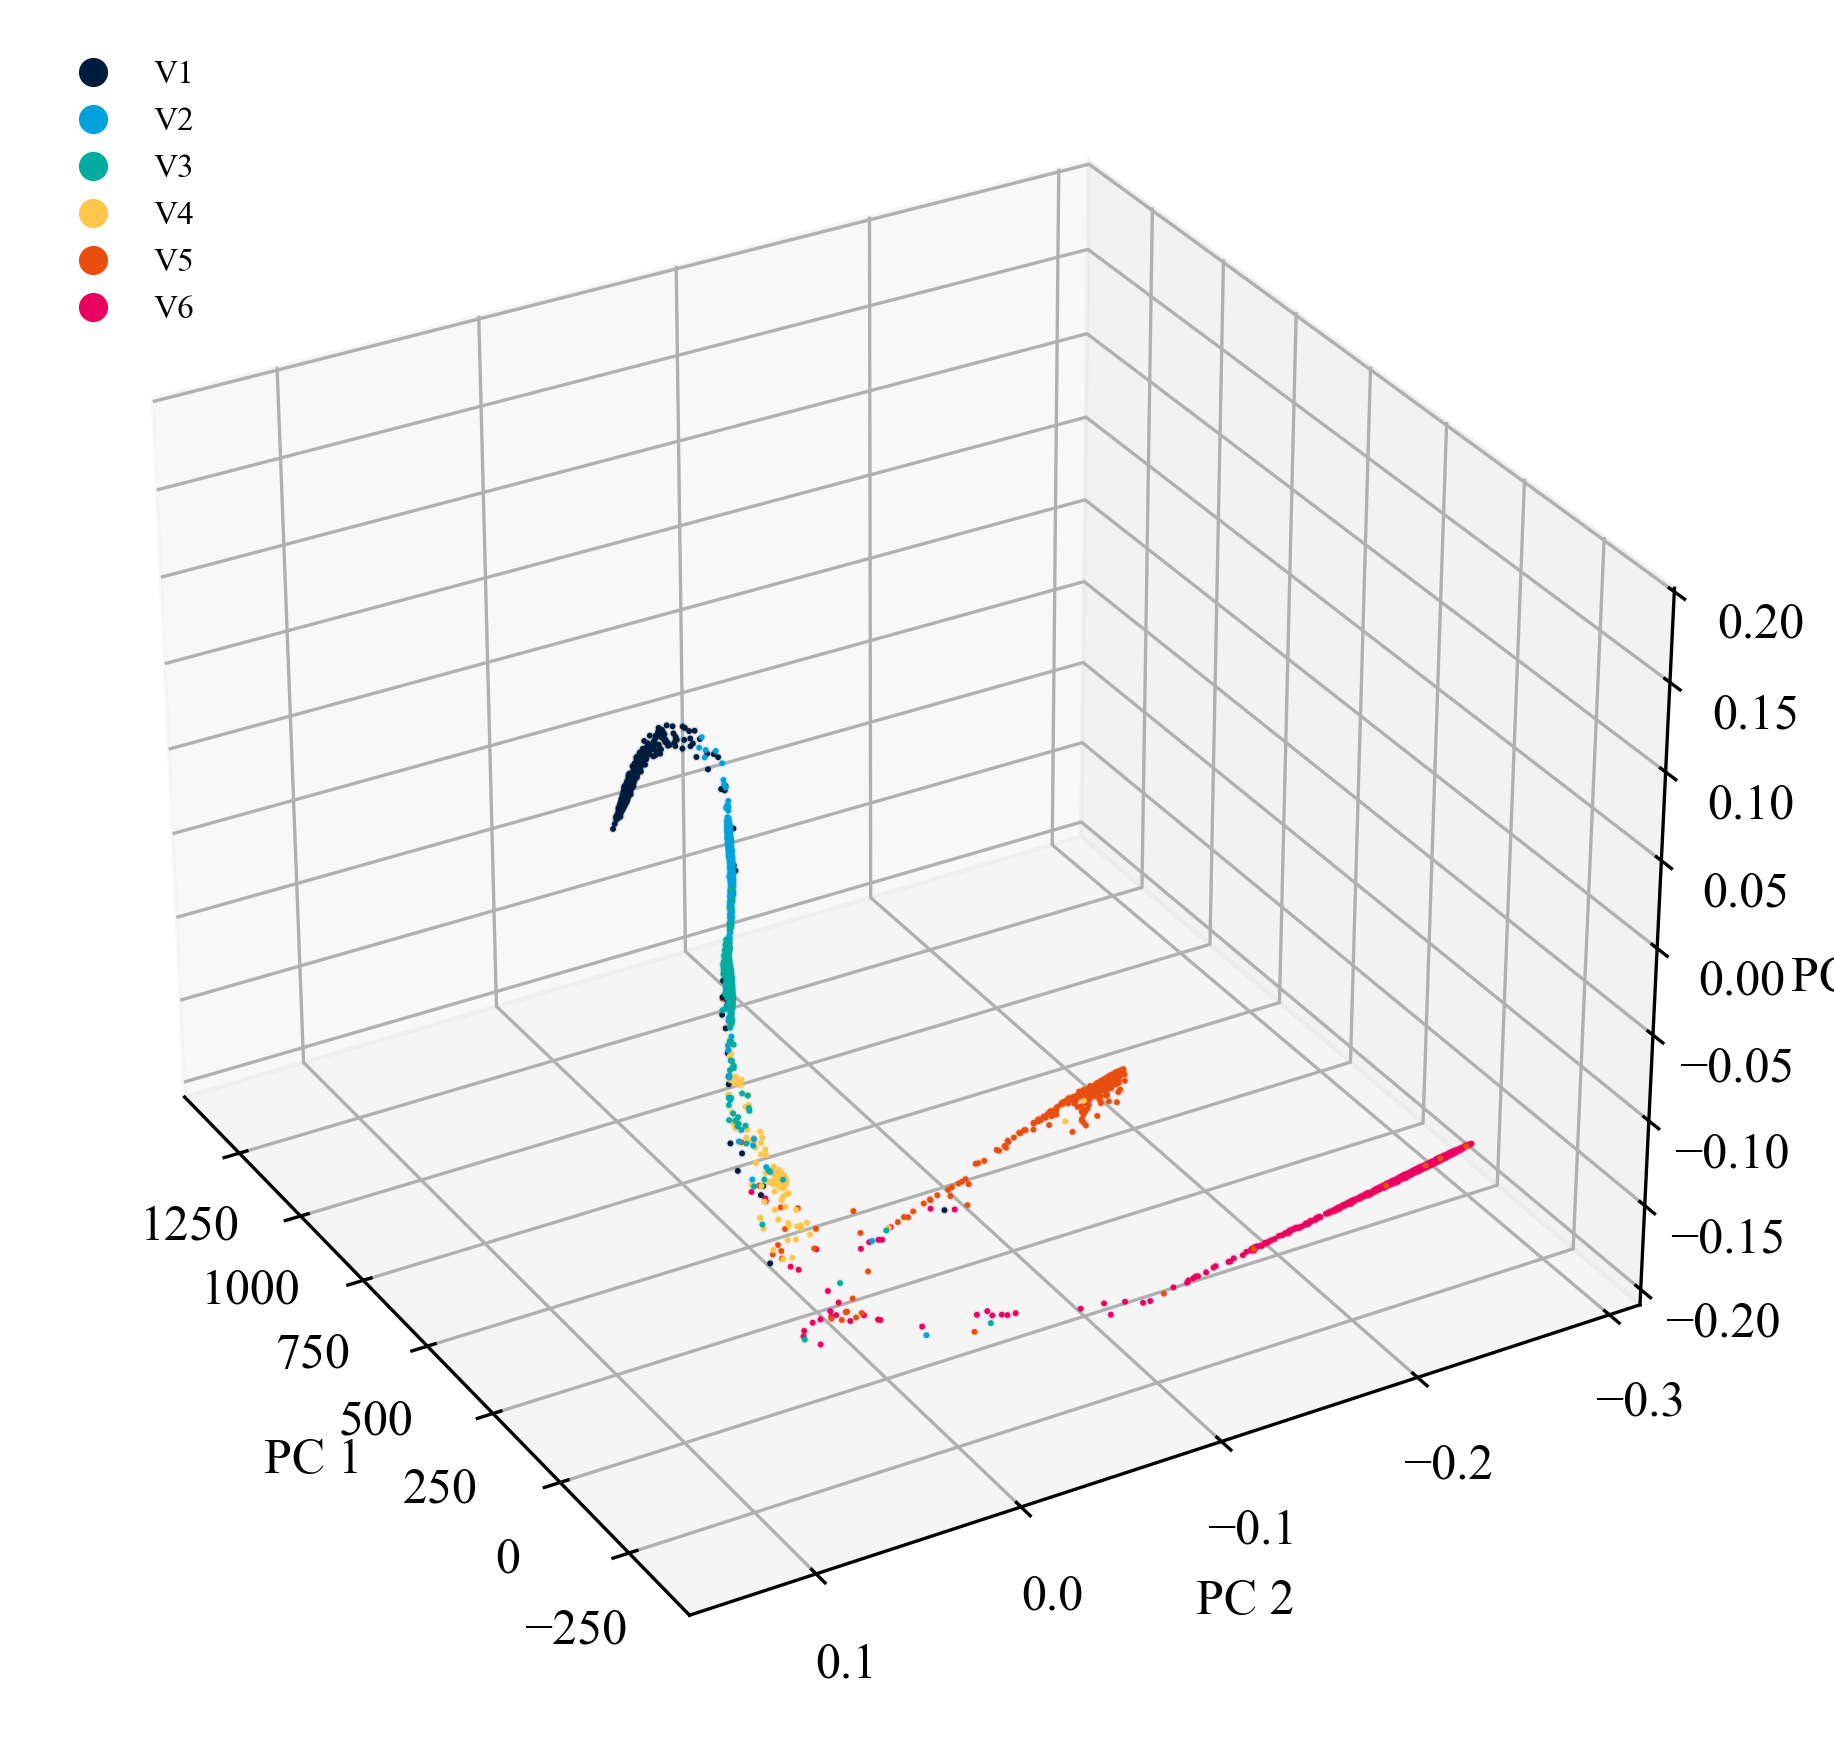

In [ ]:
import random 
#fig, ax = pretty_pca_plot(proj[:, [0, 1]], lead_labels, title="Feature Representations After Last SAB", pad=0.25,
                #alpha_front=0.9, point_size=4, num_leads=len(lead_filter))

# 3D PCA
# Reduce the number of points to plot
idxs = random.sample(range(len(lead_labels)), len(lead_labels)//4)
proj_short = proj[idxs]
lead_labels_short = lead_labels[idxs]
#angle = (50, 30)
angle = (30, 150)
fig, ax = plot_embedding_3d(proj_short, lead_labels_short, title="", pad=0.15,
                alpha_front=1, point_size=2, num_leads=len(lead_filter), lead_names=lead_filter, dpi=300,
                angle=angle)

# Save the figure
#fig.savefig(f"pca_final.png", dpi=400, bbox_inches='tight')

In [14]:
from matplotlib.animation import FuncAnimation

def spin_plot(fig, ax, elev=30, frames=360, interval=50):
    """
    Creates a spinning animation of a 3D Matplotlib plot.

    Parameters
    ----------
    fig      : matplotlib.figure.Figure
    ax       : a 3D Axes (projection='3d')
    elev     : elevation angle in degrees (fixed)
    frames   : number of frames (e.g. 360 for 1° steps)
    interval : delay between frames in ms
    Returns
    -------
    anim : FuncAnimation object
    """
    def update(azim):
        ax.view_init(elev=elev, azim=azim)
        return fig,

    anim = FuncAnimation(
        fig, update,
        frames=range(0, frames),
        interval=interval,
        blit=True
    )
    return anim

In [ ]:
anim = spin_plot(fig, ax, elev=30, frames=360, interval=100)
# Save the animation
anim.save("figures/pca_animation_planes.gif", writer='imagemagick', fps=18)

MovieWriter imagemagick unavailable; using Pillow instead.


Explained variance by each component: [0.177788   0.17464863 0.13882215]
Total explained variance: 0.49125880002975464


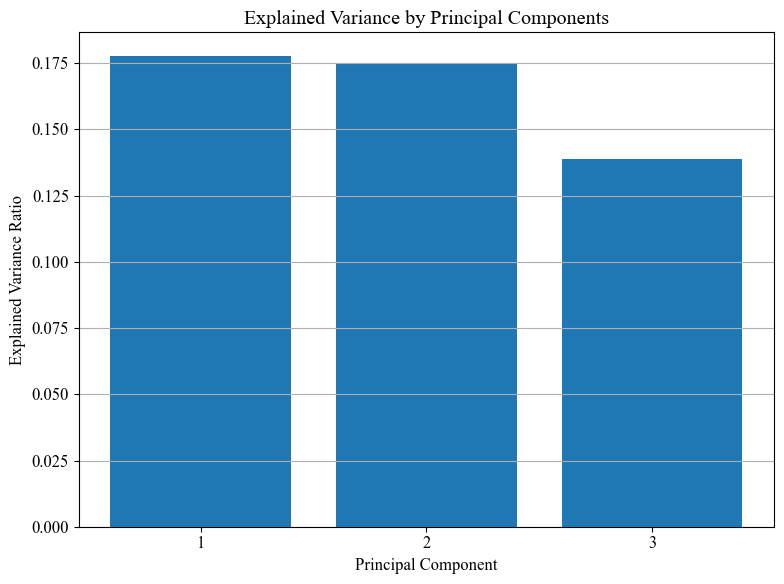

In [11]:
# Print the variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")
# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis='y')
plt.tight_layout()
